This notebook contains code to extract features from the audio signals.

In [19]:
import os
import pickle
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import librosa
import math
import random
import pandas as pd
import IPython.display
import librosa.display

ms.use('seaborn-v0_8-talk')
%matplotlib inline

In [20]:
data_dir = 'data/pre-processed/'
labels_df_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_1.pkl'.format(data_dir)
print(labels_df_path)
print(audio_vectors_path)

data/pre-processed/df_iemocap.csv
data/pre-processed/audio_vectors_1.pkl


val: Skor valensi, yang biasanya menunjukkan tingkat positif atau negatifnya emosi (misalnya 2.5).

act: Skor aktivitas, yang menunjukkan seberapa aktif atau intens emosi tersebut (misalnya 2.5 atau 3.0).

dom: Skor dominansi, yang menunjukkan tingkat kontrol atau dominasi emosi (misalnya 2.5 atau 3.0).

In [21]:
labels_df = pd.read_csv(labels_df_path)

audio_vectors = pickle.load(open(audio_vectors_path, 'rb'))
print(labels_df.head())
print(labels_df.shape)  



   start_time  end_time             wav_file emotion  val  act  dom
0      6.2901    8.2357  Ses01F_impro01_F000     neu  2.5  2.5  2.5
1     10.0100   11.3925  Ses01F_impro01_F001     neu  2.5  2.5  2.5
2     14.8872   18.0175  Ses01F_impro01_F002     neu  2.5  2.5  2.5
3     19.2900   20.7875  Ses01F_impro01_F003     xxx  2.5  3.0  3.0
4     21.3257   24.7400  Ses01F_impro01_F004     xxx  2.5  3.0  2.5
(1819, 7)


In [22]:
random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]
y = audio_vectors[random_file_name]
sr = 44100
print('File name:', random_file_name)
print('Audio shape:', y.shape)


File name: Ses01M_script02_1_F019
Audio shape: (97073,)


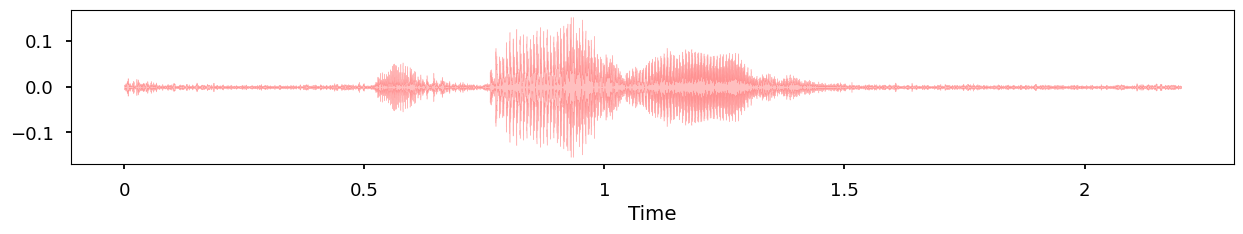

In [23]:
plt.figure(figsize=(15,2))
librosa.display.waveshow(y, sr=sr, alpha=0.25, color='r')

In [24]:
print('Signal mean = {:.5f}'.format(np.mean(abs(y))))
print('Signal std dev = {:.5f}'.format(np.std(y)))

Signal mean = 0.01020
Signal std dev = 0.02010


RMSE mean = 0.01271
RMSE std dev = 0.01554


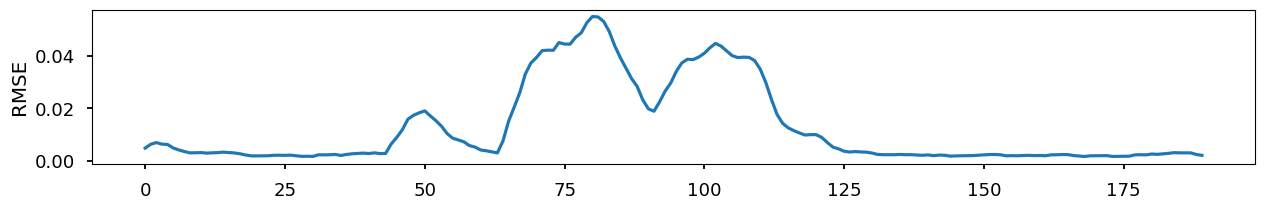

In [25]:
rmse = librosa.feature.rms(y=y + 0.0001)[0]
plt.figure(figsize=(15,2))
plt.plot(rmse)
plt.ylabel('RMSE')
print('RMSE mean = {:.5f}'.format(np.mean(rmse)))
print('RMSE std dev = {:.5f}'.format(np.std(rmse)))

In [26]:
from IPython.display import Audio
Audio(y, rate=44100)

In [27]:
silence = 0
for e in rmse:
    if e <= 0.4 * np.mean(rmse):
        silence += 1
print(silence/float(len(rmse)))

0.5789473684210527


In [28]:
y_harmonic, y_percussive = librosa.effects.hpss(y)
np.mean(y_harmonic)

-6.045586e-06

In [29]:
autocorr = librosa.core.autocorrelate(y)
np.max(autocorr)

39.21298

In [30]:
cl = 0.45 * np.mean(abs(y))
center_clipped = []
for s in y:
    if s >= cl:
        center_clipped.append(s - cl)
    elif s <= -cl:
        center_clipped.append(s + cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
np.max(new_autocorr)

31.58547640023889

In [31]:
columns = ['wav_file', 'label', 'sig_mean', 'sig_std', 'rmse_mean', 'rmse_std', 'silence', 'harmonic', 'auto_corr_max', 'auto_corr_std']
df_features = pd.DataFrame(columns=columns)

The following blocks build feature vectors for all the files

In [32]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8}

data_dir = 'data/pre-processed/'
labels_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_'.format(data_dir)

In [37]:
import os

labels_df = pd.read_csv(labels_path)
sessions = range(1, 2)  # Sesi 1 saja
session_wav_files = set()
features_list = []

for sess in sessions:
    session_wav_files.update(labels_df[labels_df['wav_file'].str.contains(f'Ses0{sess}')]['wav_file'].unique())

processed_files = set()
save_path = 'data/pre-processed/audio_features.csv'

# Jika file sudah ada, hapus agar tidak terjadi duplikasi saat append pertama kali
if os.path.exists(save_path):
    os.remove(save_path)

batch_size = 100
count = 0

for sess in sessions:
    with open(f'{audio_vectors_path}{sess}.pkl', 'rb') as f:
        audio_vectors = pickle.load(f)

    session_labels_df = labels_df[labels_df['wav_file'].str.contains(f'Ses0{sess}')]

    for _, row in tqdm(session_labels_df.iterrows(), total=len(session_labels_df)):
        wav_file_name = row['wav_file']

        if wav_file_name in processed_files:
            continue

        try:
            y = audio_vectors[wav_file_name]
            label = emotion_dict[row['emotion']]

            feature_list = [wav_file_name, label]
            sig_mean = np.mean(abs(y))
            feature_list.append(sig_mean)
            feature_list.append(np.std(y))

            rmse = librosa.feature.rms(y=y + 0.0001)[0]
            feature_list.append(np.mean(rmse))
            feature_list.append(np.std(rmse))

            silence = sum(e <= 0.4 * np.mean(rmse) for e in rmse) / len(rmse)
            feature_list.append(silence)

            y_harmonic = librosa.effects.hpss(y)[0]
            feature_list.append(np.mean(y_harmonic) * 1000)

            cl = 0.45 * sig_mean
            center_clipped = [s - cl if s >= cl else s + cl if s <= -cl else 0 for s in y]
            auto_corrs = librosa.core.autocorrelate(np.array(center_clipped))
            feature_list.append(1000 * np.max(auto_corrs) / len(auto_corrs))
            feature_list.append(np.std(auto_corrs))

            features_list.append(feature_list)
            processed_files.add(wav_file_name)
            count += 1

            # Simpan setiap batch_size data
            if count % batch_size == 0:
                df_features = pd.DataFrame(features_list, columns=columns)
                # Append ke file CSV, tanpa header jika file sudah ada
                if os.path.exists(save_path):
                    df_features.to_csv(save_path, mode='a', header=False, index=False)
                else:
                    df_features.to_csv(save_path, mode='w', header=True, index=False)
                features_list = []  # Kosongkan list setelah simpan

        except Exception as e:
            print('Processing file:', wav_file_name)
            print('Some exception occurred: {}'.format(e))

# Simpan sisa data yang belum disimpan jika ada
if features_list:
    df_features = pd.DataFrame(features_list, columns=columns)
    if os.path.exists(save_path):
        df_features.to_csv(save_path, mode='a', header=False, index=False)
    else:
        df_features.to_csv(save_path, mode='w', header=True, index=False)


 42%|████▏     | 770/1819 [06:55<11:37,  1.50it/s]

Processing file: Ses01F_script03_1_M030
Some exception occurred: 'dis'


100%|██████████| 1819/1819 [15:58<00:00,  1.90it/s]


coba jalankan 50 data saja untuk cek data

In [34]:
labels_df = pd.read_csv(labels_path)
sessions = range(1, 2)  # Sesi 1 saja
session_wav_files = set()
features_list = []

for sess in sessions:
    session_wav_files.update(labels_df[labels_df['wav_file'].str.contains(f'Ses0{sess}')]['wav_file'].unique())

processed_files = set()

for sess in sessions:
    with open(f'{audio_vectors_path}{sess}.pkl', 'rb') as f:
        audio_vectors = pickle.load(f)

    session_labels_df = labels_df[labels_df['wav_file'].str.contains(f'Ses0{sess}')]

    # Batasi hanya 50 data pertama
    session_labels_df = session_labels_df.head(50)

    for _, row in tqdm(session_labels_df.iterrows(), total=len(session_labels_df)):
        wav_file_name = row['wav_file']

        if wav_file_name in processed_files:
            continue

        try:
            y = audio_vectors[wav_file_name]  # Pastikan variabel y didefinisikan
            label = emotion_dict[row['emotion']]

            feature_list = [wav_file_name, label]
            sig_mean = np.mean(abs(y))
            feature_list.append(sig_mean)
            feature_list.append(np.std(y))

            rmse = librosa.feature.rms(y=y + 0.0001)[0]
            feature_list.append(np.mean(rmse))
            feature_list.append(np.std(rmse))

            silence = sum(e <= 0.4 * np.mean(rmse) for e in rmse) / len(rmse)
            feature_list.append(silence)

            y_harmonic = librosa.effects.hpss(y)[0]
            feature_list.append(np.mean(y_harmonic) * 1000)

            cl = 0.45 * sig_mean
            center_clipped = [s - cl if s >= cl else s + cl if s <= -cl else 0 for s in y]
            auto_corrs = librosa.core.autocorrelate(np.array(center_clipped))
            feature_list.append(1000 * np.max(auto_corrs) / len(auto_corrs))
            feature_list.append(np.std(auto_corrs))

            features_list.append(feature_list)
            processed_files.add(wav_file_name)

        except Exception as e:
            print('Processing file:', wav_file_name)
            print('Some exception occurred: {}'.format(e))

df_features = pd.DataFrame(features_list, columns=columns)
df_features.to_csv('data/pre-processed/audio_features_dikit.csv', index=False)


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]
